## Modelo: Red Neuronal

Importo las librerias que utilizare.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras import Sequential
import ipywidgets as widgets
from sklearn.preprocessing import OrdinalEncoder
import warnings 
warnings.filterwarnings('ignore')
from keras.metrics import MeanSquaredError
from keras.losses import MeanSquaredError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# from tensorflow.keras import models
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

### Lectura de archivos

Leo arc Shippings 

In [3]:
ship = pd.read_csv('silkroad_shippings.csv')

Leo arc Reviews

In [4]:
rev = pd.read_csv('silkroad_reviews.csv')

In [5]:
rev = rev[['item_id','rating']]

In [6]:
rev.shape

(314209, 2)

Hay varios ratings asociados al mismo item_id, por lo tanto voy a quedarme con el rating promedio por cada item_id.

In [7]:
grouped_rev = rev.groupby('item_id').agg({'rating':'mean'})

In [8]:
grouped_rev.shape

(12749, 1)

In [9]:
grouped_rev.reset_index(inplace=True)

Realizo el join entre los dos arc que leí.

In [10]:
join = ship.merge(grouped_rev,how='left')

In [11]:
join.shape

(560458, 6)

Modifico el formato del timestamp

In [12]:
# formateo el timestamp del join
join['timestamp'] =pd.to_datetime(join["timestamp"]).dt.strftime('%Y-%m-%d')

Leo el arc de bitcoins

In [13]:
bit = pd.read_csv('bitcoins.csv')

In [14]:
bit['Date'] = pd.to_datetime(bit['Date']).dt.strftime('%Y-%m-%d')

In [15]:
bit = bit[['Date','Price']].rename(columns={'Price':'EuroPrice'})

In [16]:
merge = join.merge(bit,left_on='timestamp',right_on ='Date',how = 'left')

In [17]:
merge['bit_en_euro'] = merge['price']*merge['EuroPrice']

Voy a trabajar con todos los precios del shipping menores o igual a 100 Euros.

In [18]:
#achico mi rango de precios AGREGUE RECIEN
merge = merge[merge['bit_en_euro'] <= 100]

In [19]:
# Libero RAM
del(merge['price'])
del(merge['Date'])
del(merge['EuroPrice'])
del(merge['item_id'])
del join
del ship
del rev
del grouped_rev

In [20]:
merge = merge.sort_values(by='timestamp', ascending=True)

In [21]:
del(merge['timestamp'])

Los features que usare son:
   * description
   * est_delivery
   * ratting

### Realizo la division en train y test.

Tomo el limite para dividir el test del train

In [22]:
index_limite = int(merge.shape[0] * 0.8 )

In [23]:
limite = merge.index[index_limite]

Train

In [24]:
train =  merge[merge.index <= limite]

In [25]:
train.shape

(440527, 4)

In [26]:
trainLabel = train['bit_en_euro']

In [27]:
del(train['bit_en_euro'])

Test

In [28]:
test =  merge[merge.index > limite]

In [29]:
test.shape

(111840, 4)

In [30]:
testLabel = test['bit_en_euro']

In [31]:
del(test['bit_en_euro'])

### Encodings

Diccionario de encodigns

In [32]:
encoding = {}

Funciones para los encodings.

In [33]:
def countVect(df,columna,dic):
    if columna not in dic:
        dic[columna]=Pipeline([('countV', CountVectorizer(max_features =5000)), ('TruncatedSVD', TruncatedSVD(n_components=50, n_iter=3, random_state=0))])
        col_encoded = dic[columna].fit_transform(df[columna].fillna('desconocido'))
    else:
        col_encoded = dic[columna].transform(df[columna].fillna('desconocido'))
    col_encoded = pd.DataFrame(col_encoded).add_prefix(columna+ '_enconded_').fillna(0) #imputacion de nulos
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True),col_encoded], axis=1)
    return df_nuevo
    #la imputacion de nulos se realiza reemplazando los mismos por 'desconocido'

In [34]:
def ordinal_enc(df,dic):
    for column in df.columns:
        if df[column].dtypes==object:
            dic[column] = OrdinalEncoder(handle_unknown='ignore')
            df[column] = dic[column].fit_transform(df[column].astype(str).values.reshape(-1, 1))
    if df[column].dtype==object:
        df[column] = dic[column].transform(df[column].astype(str).values.reshape(-1, 1))
    df.fillna(-1,inplace=True) #imputacion de nulos
    return(df)

### Train

In [35]:
train.columns

Index(['description', 'est_delivery', 'rating'], dtype='object')

Realizo los encodings en el train.

In [36]:
train = countVect(train,'description',encoding)

In [37]:
train = ordinal_enc(train,encoding)

Muestro los encoders

In [38]:
encoding

{'description': Pipeline(steps=[('countV', CountVectorizer(max_features=5000)),
                 ('TruncatedSVD',
                  TruncatedSVD(n_components=50, n_iter=3, random_state=0))]),
 'est_delivery': OrdinalEncoder(handle_unknown='ignore')}

### Validation

Realizo los encodings en el validation

In [39]:
test = countVect(test,'description',encoding)

In [40]:
test = ordinal_enc(test,encoding)

#### Trabajo con el modelo

In [41]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [42]:
train.shape

(440527, 52)

In [43]:
model = Sequential()
model.add(Dense(50, input_dim=52, activation='tanh'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(30, activation='tanh'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(30, activation='tanh'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(1, activation='relu'))

In [44]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"]) 

Muestro las caracteristicas de la red.

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2650      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                9

Creo el objeto de EarlyStopping

In [46]:
stop= EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True) 

### Entreno la red.

In [47]:
# fit the keras model on the dataset
resultado=model.fit(train.values, 
          trainLabel.values,
          epochs=300,
          callbacks=[stop],
          batch_size=4096,
          verbose=2,
          validation_split=0.2,
)

Epoch 1/300
87/87 - 1s - loss: 837.2511 - mae: 9.8055 - val_loss: 188.3120 - val_mae: 9.5911 - 1s/epoch - 17ms/step
Epoch 2/300
87/87 - 1s - loss: 790.3436 - mae: 9.5734 - val_loss: 179.2655 - val_mae: 8.9465 - 667ms/epoch - 8ms/step
Epoch 3/300
87/87 - 1s - loss: 747.2715 - mae: 7.9751 - val_loss: 117.2978 - val_mae: 6.6999 - 636ms/epoch - 7ms/step
Epoch 4/300
87/87 - 1s - loss: 717.4698 - mae: 7.1895 - val_loss: 106.0748 - val_mae: 6.2280 - 625ms/epoch - 7ms/step
Epoch 5/300
87/87 - 1s - loss: 708.8563 - mae: 6.9589 - val_loss: 99.4378 - val_mae: 5.9429 - 617ms/epoch - 7ms/step
Epoch 6/300
87/87 - 1s - loss: 703.6380 - mae: 6.8030 - val_loss: 95.2400 - val_mae: 5.9024 - 628ms/epoch - 7ms/step
Epoch 7/300
87/87 - 1s - loss: 699.2247 - mae: 6.6690 - val_loss: 88.7888 - val_mae: 5.5028 - 595ms/epoch - 7ms/step
Epoch 8/300
87/87 - 1s - loss: 694.7429 - mae: 6.5327 - val_loss: 82.5457 - val_mae: 5.2834 - 663ms/epoch - 8ms/step
Epoch 9/300
87/87 - 1s - loss: 691.4395 - mae: 6.4285 - val_lo

Epoch 71/300
87/87 - 1s - loss: 655.7139 - mae: 5.0169 - val_loss: 47.6650 - val_mae: 3.6862 - 601ms/epoch - 7ms/step
Epoch 72/300
87/87 - 1s - loss: 655.6973 - mae: 5.0208 - val_loss: 47.6009 - val_mae: 3.6943 - 598ms/epoch - 7ms/step
Epoch 73/300
87/87 - 1s - loss: 655.5065 - mae: 5.0060 - val_loss: 47.5235 - val_mae: 3.7076 - 600ms/epoch - 7ms/step
Epoch 74/300
87/87 - 1s - loss: 655.1845 - mae: 4.9974 - val_loss: 47.3325 - val_mae: 3.6982 - 600ms/epoch - 7ms/step
Epoch 75/300
87/87 - 1s - loss: 654.9709 - mae: 4.9817 - val_loss: 47.1857 - val_mae: 3.6963 - 600ms/epoch - 7ms/step
Epoch 76/300
87/87 - 1s - loss: 655.0101 - mae: 4.9873 - val_loss: 47.8549 - val_mae: 3.6833 - 600ms/epoch - 7ms/step
Epoch 77/300
87/87 - 1s - loss: 655.1437 - mae: 4.9958 - val_loss: 47.7119 - val_mae: 3.6641 - 600ms/epoch - 7ms/step
Epoch 78/300
87/87 - 1s - loss: 654.6590 - mae: 4.9783 - val_loss: 47.0806 - val_mae: 3.6816 - 602ms/epoch - 7ms/step
Epoch 79/300
87/87 - 1s - loss: 654.9606 - mae: 4.9771 -

87/87 - 1s - loss: 649.4948 - mae: 4.7349 - val_loss: 43.2377 - val_mae: 3.4677 - 622ms/epoch - 7ms/step
Epoch 141/300
87/87 - 1s - loss: 648.6568 - mae: 4.7178 - val_loss: 43.1737 - val_mae: 3.4563 - 621ms/epoch - 7ms/step
Epoch 142/300
87/87 - 1s - loss: 648.6094 - mae: 4.7113 - val_loss: 43.0456 - val_mae: 3.4411 - 613ms/epoch - 7ms/step
Epoch 143/300
87/87 - 1s - loss: 648.7228 - mae: 4.7140 - val_loss: 43.0798 - val_mae: 3.4397 - 599ms/epoch - 7ms/step
Epoch 144/300
87/87 - 1s - loss: 648.8099 - mae: 4.7083 - val_loss: 42.8995 - val_mae: 3.3987 - 650ms/epoch - 7ms/step
Epoch 145/300
87/87 - 1s - loss: 649.0083 - mae: 4.7132 - val_loss: 43.0631 - val_mae: 3.4466 - 625ms/epoch - 7ms/step
Epoch 146/300
87/87 - 1s - loss: 648.6672 - mae: 4.7072 - val_loss: 42.8975 - val_mae: 3.4330 - 607ms/epoch - 7ms/step
Epoch 147/300
87/87 - 1s - loss: 648.9336 - mae: 4.6990 - val_loss: 43.1464 - val_mae: 3.4193 - 611ms/epoch - 7ms/step
Epoch 148/300
87/87 - 1s - loss: 648.5136 - mae: 4.6916 - val_

Epoch 209/300
87/87 - 1s - loss: 645.9401 - mae: 4.5991 - val_loss: 40.5941 - val_mae: 3.3355 - 608ms/epoch - 7ms/step
Epoch 210/300
87/87 - 1s - loss: 645.9384 - mae: 4.5965 - val_loss: 40.6139 - val_mae: 3.3068 - 620ms/epoch - 7ms/step
Epoch 211/300
87/87 - 1s - loss: 645.6833 - mae: 4.5825 - val_loss: 40.6200 - val_mae: 3.3534 - 626ms/epoch - 7ms/step
Epoch 212/300
87/87 - 1s - loss: 646.3837 - mae: 4.6008 - val_loss: 40.5933 - val_mae: 3.3354 - 670ms/epoch - 8ms/step
Epoch 213/300
87/87 - 1s - loss: 645.6771 - mae: 4.5914 - val_loss: 40.3749 - val_mae: 3.3371 - 622ms/epoch - 7ms/step
Epoch 214/300
87/87 - 1s - loss: 645.8580 - mae: 4.5883 - val_loss: 40.2124 - val_mae: 3.3154 - 640ms/epoch - 7ms/step
Epoch 215/300
87/87 - 1s - loss: 645.4663 - mae: 4.5862 - val_loss: 40.4738 - val_mae: 3.3231 - 645ms/epoch - 7ms/step
Epoch 216/300
87/87 - 1s - loss: 646.3159 - mae: 4.5909 - val_loss: 40.4629 - val_mae: 3.3212 - 624ms/epoch - 7ms/step
Epoch 217/300
87/87 - 1s - loss: 645.7576 - mae:

Epoch 278/300
87/87 - 1s - loss: 644.6058 - mae: 4.5473 - val_loss: 39.2553 - val_mae: 3.2567 - 627ms/epoch - 7ms/step
Epoch 279/300
87/87 - 1s - loss: 644.1309 - mae: 4.5373 - val_loss: 38.8579 - val_mae: 3.2409 - 635ms/epoch - 7ms/step
Epoch 280/300
87/87 - 1s - loss: 644.2305 - mae: 4.5329 - val_loss: 38.9206 - val_mae: 3.2435 - 629ms/epoch - 7ms/step
Epoch 281/300
87/87 - 1s - loss: 644.6959 - mae: 4.5540 - val_loss: 38.9973 - val_mae: 3.2380 - 632ms/epoch - 7ms/step
Epoch 282/300
87/87 - 1s - loss: 644.1569 - mae: 4.5230 - val_loss: 38.9466 - val_mae: 3.2325 - 622ms/epoch - 7ms/step
Epoch 283/300
87/87 - 1s - loss: 644.0291 - mae: 4.5288 - val_loss: 38.9277 - val_mae: 3.2575 - 638ms/epoch - 7ms/step
Epoch 284/300
87/87 - 1s - loss: 644.3662 - mae: 4.5399 - val_loss: 38.8821 - val_mae: 3.2255 - 642ms/epoch - 7ms/step
Epoch 285/300
87/87 - 1s - loss: 644.7382 - mae: 4.5407 - val_loss: 39.2687 - val_mae: 3.2670 - 615ms/epoch - 7ms/step
Epoch 286/300
87/87 - 1s - loss: 644.4563 - mae:

### Grafico sobre la loss

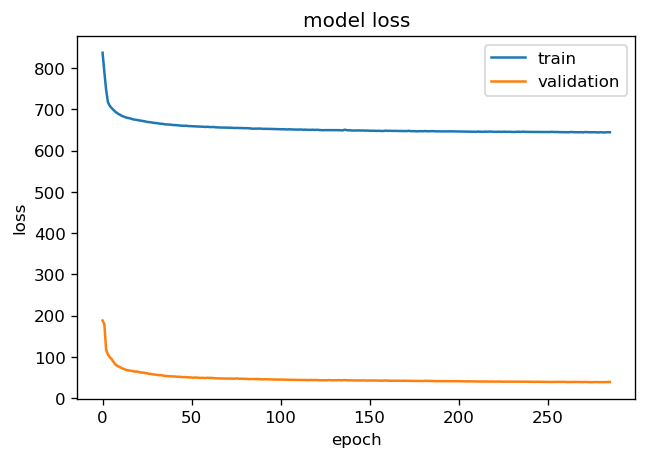

In [48]:
plt.figure(dpi=120)
plt.plot(resultado.history["loss"])
plt.plot(resultado.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")

### Grafico el MAE

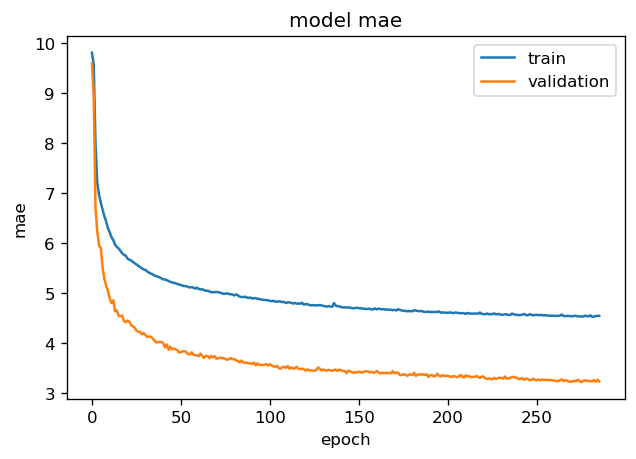

In [49]:
plt.figure(dpi=120)
plt.plot(resultado.history["mae"])
plt.plot(resultado.history["val_mae"])
plt.title("model mae")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")

### Realizo la predicción

In [50]:
y_predict=model.predict(test)

In [51]:
y_predict

array([[ 8.890722],
       [ 5.520507],
       [ 5.520507],
       ...,
       [ 8.138536],
       [16.12886 ],
       [20.614296]], dtype=float32)

### Calculo de las metricas de medicion
* Error cuadratico medio
* Error absoluto medio

In [52]:
mean_squared_error(testLabel,  y_predict)

51.17841816792468

In [53]:
mean_absolute_error(testLabel,  y_predict)

3.677061571027796

### Curva de calibracion

In [54]:
r, p = sp.stats.pearsonr(testLabel.to_numpy().flatten(), y_predict.flatten())
r2 = r**2
print('r2: ', r2, ' p: ',p)

r2:  0.73506899570775  p:  0.0


Text(0.05, 0.9, 'r2=0.74, p=0')

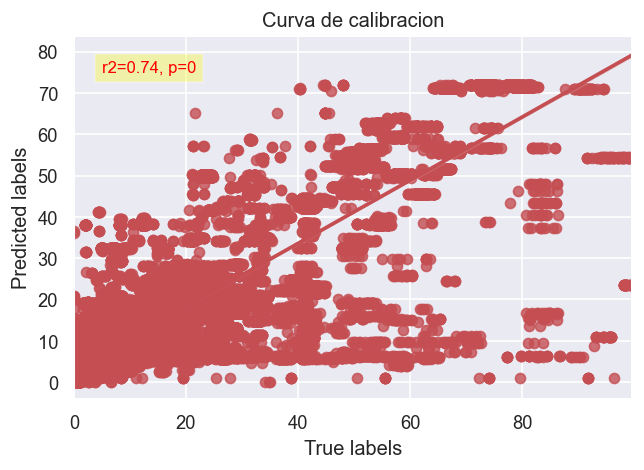

In [55]:
sns.set(rc={"figure.dpi":120})
curvaCalibracion = sns.regplot(testLabel.to_numpy().flatten(), y_predict.flatten(), color='r')
curvaCalibracion.set_xlabel('True labels', fontsize = 12)
curvaCalibracion.set_ylabel('Predicted labels', fontsize = 12)
curvaCalibracion.set_title('Curva de calibracion', fontsize = 12)
curvaCalibracion.text(.05, .9, 'r2={:.2f}, p={:.2g}'.format(r2, p),
            transform=curvaCalibracion.transAxes,fontdict=dict(color='red',size=10),
                      bbox=dict(facecolor='yellow',alpha=0.3))

### Residual Plots

Text(41.87500000000001, 0.5, 'Predicted labels')

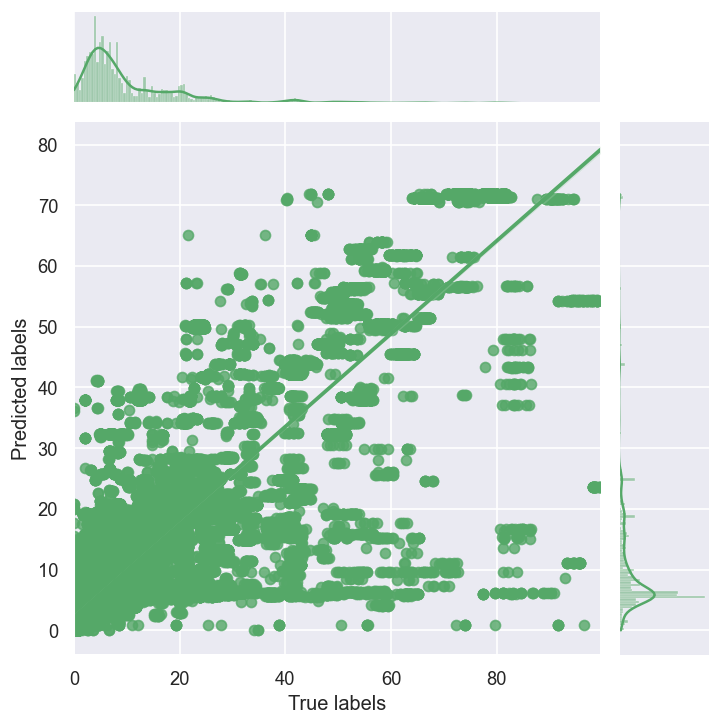

In [56]:
sns.set(rc={"figure.dpi":120})
jointp = sns.jointplot(x = testLabel.values.flatten(), y = y_predict.flatten(), kind="reg", color ='g')
jointp.ax_joint.set_xlabel('True labels', fontsize = 12)
jointp.ax_joint.set_ylabel('Predicted labels', fontsize = 12)
#el de arriba es el label, el del costado es la prediccion

In [57]:
info_histo = (testLabel.to_numpy().flatten()-y_predict.flatten())

Text(0.5, 1.0, 'Distribucion gaussiana del error')

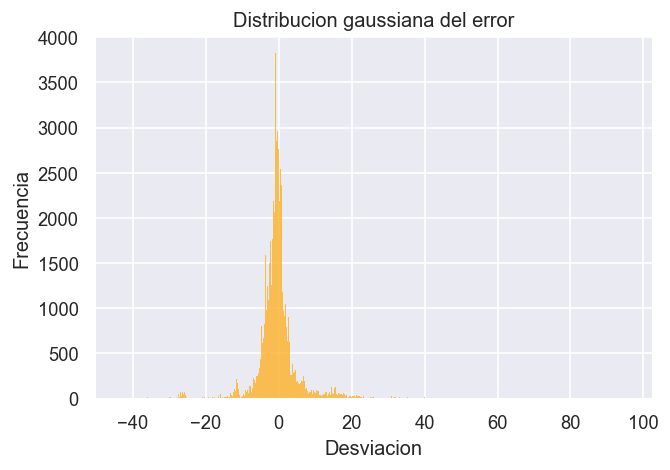

In [58]:
sns.set(rc={"figure.dpi":120})
histo = sns.histplot(x=info_histo, color ='orange')
histo.set_xlabel('Desviacion', fontsize = 12)
histo.set_ylabel('Frecuencia', fontsize = 12)
histo.set_title('Distribucion gaussiana del error', fontsize = 12)

***Conclusión:*** podemos observar que en éste modelo hemos obtenido mejores resultados. Dado que la métrica nos da un resultado mucho mejor y se observa lo mismo con la calibración del modelo.